In [51]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import scipy as sp
import spiceypy as spice
from scipy import constants
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jplephem as jpl #jpl spk, open kernal , date -> days
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon, get_body_barycentric_posvel
from astropy import units as u
import astropy as ap

In [2]:
#CONSTANTS
G = constants.G
c = constants.speed_of_light
AU = 1.496e8 #km
JD = 3600*24 #s

#MASSES
M_sun = 1.99e30
M_merc = 3.30e23 
M_venus = 4.87e24
M_earth = 5.97e24
M_moon = 7.35e22
M_mars = 6.42e23
M_jup = 1.90e27
M_sat = 5.68e26
M_uran = 8.68e25
M_nept = 1.02e26
M_pluto = 1.31e22
ss_mass = [M_sun, M_merc, M_venus, M_earth, M_moon, M_mars, M_jup, M_sat, M_uran, M_nept, M_pluto]

#SEM system
SEM = ['sun','earth','moon']
sem_masses = [M_sun, M_earth, M_moon]

In [3]:
#JPL Model of the Solar System + intial Times
solar_system_ephemeris.set('de430.bsp') #file path
#directory: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/
solar_bodies = list(solar_system_ephemeris.bodies) #list of bodies, tuple to list
solar_bodies.remove('earth-moon-barycenter')
print("list of bodies:", solar_bodies)
t_i = Time("2000-09-27 11:11")

list of bodies: ['sun', 'mercury', 'venus', 'earth', 'moon', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune', 'pluto']


In [4]:
#ROTATION
from math import pi ,sin, cos

def R(theta, u):
    return [[cos(theta) + u[0]**2 * (1-cos(theta)), 
             u[0] * u[1] * (1-cos(theta)) - u[2] * sin(theta), 
             u[0] * u[2] * (1 - cos(theta)) + u[1] * sin(theta)],
            [u[0] * u[1] * (1-cos(theta)) + u[2] * sin(theta),
             cos(theta) + u[1]**2 * (1-cos(theta)),
             u[1] * u[2] * (1 - cos(theta)) - u[0] * sin(theta)],
            [u[0] * u[2] * (1-cos(theta)) - u[1] * sin(theta),
             u[1] * u[2] * (1-cos(theta)) + u[0] * sin(theta),
             cos(theta) + u[2]**2 * (1-cos(theta))]]

def Rotate(VecToRotate, u, theta):
    n = u/np.linalg.norm(u)
    r = R(theta, n)
    
    rotated = np.matmul(r,VecToRotate)

    return rotated


point = [1,1,2]
z = [1,1,1]

print (Rotate(point, z, pi/2)) 

[1.9106836  0.75598306 1.33333333]


In [5]:
"FUNCTION FOR GENERATING ORBITAL DATA -> posvel"
"N.B. SUN[0], EARTH[3], MOON[4]"
#Solar System Orbit F(t)
def Orbits (ti, d=2, dt=2000, ntdata=500, bodies = solar_bodies, plot=True, plotvel=True): 
    """
    INPUT: 
    ti - start time in isot
    dt - interval in JD
    ntdata - no. of t data
    bodies- list of bodies
    
    OUTPUT:
    positions - matrix of positions
    allt - time sequence
    """
    print("D =",d) #check
    n_b = len(bodies) #number of bodies
    #create empty 2d arrays
    positions = np.empty([n_b, ntdata, 3]) #rows=bodies
    velocities = np.empty([n_b, ntdata])
    
    #all time
    allt = ti + dt * np.linspace(0., 1., ntdata)
    print("end time =", allt[-1])
    
    for i in range(n_b):
        for j in range (ntdata):
            output = get_body_barycentric_posvel(bodies[i],allt[j]) #get position and velocity
            positions[i][j] = list((output[0].get_xyz().to_value())*6.68459e-9) #unit = AU
            velocities[i][j] = np.linalg.norm(output[1].get_xyz().to_value()) #magvel, unit = AU/day
   
    #L-Points appox
    possun = positions[0]
    posearth = positions[3]
    r_se = positions[0]-positions[3]#sun-earth dist
    planenorm1 = np.cross(possun[0],posearth[0])
    planenorm2 = np.cross(possun[50],posearth[50])
    print(planenorm1, planenorm2)
    
    L1 = np.empty([ntdata,3])
    L2 = np.empty([ntdata,3])
    L3 = np.empty([ntdata,3])
    L4 = np.empty([ntdata,3])
    L5 = np.empty([ntdata,3])
    for i in range(ntdata):
        L1[i] = (1-((M_earth/(M_sun + M_earth))**(1/3)))*r_se[i]
        L2[i] = (1+((M_earth/(M_sun + M_earth))**(1/3)))*r_se[i]
        L3[i] = (-1-((5*M_earth)/(12*(M_sun + M_earth))))*r_se[i]
        L4[i] = Rotate(posearth[i],np.cross(r_se[i],possun[i]),-pi/3)
        L5[i] = Rotate(posearth[i],np.cross(r_se[i],possun[i]),pi/3)
    
    L_points = np.stack((L1,L2,L3,L4,L5))
    
    if plot == True:
        #2D
        if d == 2:
            plt.figure(figsize=(20,6))
            for i in range(n_b):
                x_singlebody = np.transpose(positions[i])
                plt.plot(x_singlebody[0],x_singlebody[1],'--',label=bodies[i])
            x_l1 = np.transpose(L1)
            x_l2 = np.transpose(L2)
            x_l3 = np.transpose(L3)
            x_l4 = np.transpose(L4)
            x_l5 = np.transpose(L5)
            plt.plot(x_l1[0],x_l1[1],label='L1')
            plt.plot(x_l2[0],x_l2[1],label='L2')
            plt.plot(x_l3[0],x_l3[1],label='L3')
            plt.plot(x_l4[0],x_l4[1],'x',label='L4')
            plt.plot(x_l5[0],x_l5[1],'x',label='L5')
            plt.legend()
            #plt.xlim(-2,-2)
            #plt.ylim(-2,-2)
            plt.title('Solar System Orbits')
            plt.show()
        
        #3D
        if d == 3:
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(projection = '3d')
            for i in range (n_b):
                x_singlebody = np.transpose(positions[i])
                ax.plot3D(x_singlebody[0],x_singlebody[1],x_singlebody[2],label = bodies[i])
            plt.legend()
            plt.title('Solar System Orbits')
            plt.show()
    
    #plot velocity
    if plotvel == True:
        plt.figure(figsize=(20,6))
        allt_jd = np.empty(len(allt))
        for nt in range(len(allt)):
            allt_jd[nt] = allt[nt].jd
        for i in range(n_b):
            v_singlebody = velocities[i]
            plt.plot(allt_jd,v_singlebody,'--',label=bodies[i])
        plt.legend()
        plt.title('Solar System Velocities')
        plt.ylabel('v (AU/day)')
        plt.xlabel('t (JD)')
        plt.show()
                  
    return positions, allt, L_points, velocities

D = 2
end time = 2006-03-20 11:10:59.000
[-1.38780024e-05 -1.45380787e-03  3.78308246e-03] [-3.07387384e-05  6.64611857e-04 -1.54959097e-03]


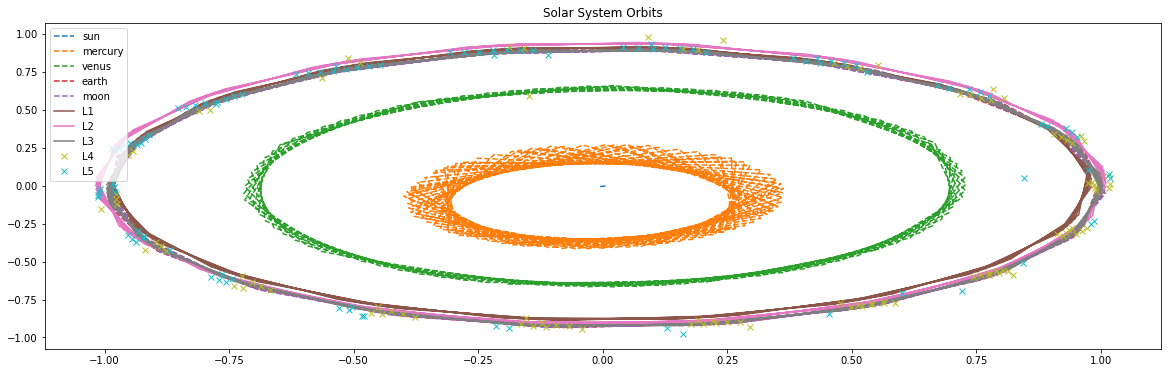

array([[ 0.99349976,  0.0702726 ,  0.03064978],
       [ 0.90080755,  0.37599941,  0.1631984 ],
       [ 0.69868245,  0.63573655,  0.27580515],
       [ 0.41028292,  0.81680296,  0.3542989 ],
       [ 0.0703085 ,  0.89565973,  0.38848248],
       [-0.2790967 ,  0.86169329,  0.37375734],
       [-0.59399411,  0.71896546,  0.31187388],
       [-0.83512015,  0.48565971,  0.21071583],
       [-0.97337328,  0.19147736,  0.08316916],
       [-0.9932661 , -0.12674771, -0.05479684],
       [-0.89418322, -0.43038027, -0.18644071],
       [-0.68976675, -0.6838525 , -0.29634124],
       [-0.40546188, -0.85840798, -0.37202283],
       [-0.07490726, -0.93480563, -0.40514461],
       [ 0.26391161, -0.90505418, -0.39225179],
       [ 0.57235344, -0.77284815, -0.33494299],
       [ 0.81496762, -0.5529542 , -0.2396113 ],
       [ 0.96325422, -0.26990301, -0.11689626],
       [ 0.99877936,  0.04400523,  0.019191  ],
       [ 0.91554084,  0.3519272 ,  0.15268105],
       [ 0.7215294 ,  0.61664247,  0.267

In [6]:
#%%capture
#2D Orbits
testout = Orbits (t_i,2,2000,100,['sun', 'mercury', 'venus', 'earth', 'moon'],True,False)
L1 = testout[2][3]
L2 = testout[2][4]
testout[0][3]

In [31]:
#Relative Distances
def RelDist(t,R,bodies,allpos,plot=True):
    """
    t=time array
    R = position of a given POINT relative to the SUN
        or
        array of a position at all time
    bodies = list of bodies --- MAKE SURE 'sun' IS THE FIRST ITEM!!
    allpos = array of pos (position for all bodies at all time)
    """
    r_sun = allpos[0] #position of the sun
    
    relpos=[] #list for all planet positions relative to the sun
    for i in range(len(bodies)):
        relative_r = r_sun - allpos[i]
        relpos.append(relative_r)
    
    if len(R) == len(r_sun):
        posR = R
    
    else: #making R a list if R is a POINT
        posR = len(t)*[R]
    
    posSB = [] #list for positions of point relative to all the bodies
    for i in relpos:
        posSB.append(posR - i)
    
    
    #calculating the norm of vectors
    rSB = np.empty([len(posSB),(len(posSB[0]))])
    for i in range(len(posSB)):
        for j in range(len(posSB[0])):
            rSB[i][j] = np.linalg.norm(posSB[i][j])
    
    #plot
    if plot == True:
        plt.figure(figsize=(20,6))
        for i in range(len(rSB)):
            plt.plot(t.jd, rSB[i], label=bodies[i])
        plt.xlabel('t (JD)')
        plt.ylabel('x (AU)')
        plt.legend()
        plt.title('Relative Distances')
        plt.show()
    
    return posSB, rSB


In [33]:
def dtau (M,r,dt):
    """
    dt in JD (time period integrated over)
    r in AU (distance away from r, scalar)
    
    dtau = proper time at r due to M in s
    """
    dtau = (np.sqrt(1-((2*G*M)/(r*AU*((c)**2)))))*dt*JD
    return dtau              

In [32]:
output3 = Orbits (t_i, 2, 6000, 6000, solar_bodies,False, False)
allpos, t3 = output3[0], output3[1]
lp3 = output3[2]

D = 2
end time = 2017-03-02 11:10:55.000
[-1.38780024e-05 -1.45380787e-03  3.78308246e-03] [-0.00013105  0.00060176 -0.00115219]


In [34]:
L1_3 = lp3[0]
L2_3 = lp3[1]
L3_3 = lp3[2]
L4_3 = lp3[3]
L5_3 = lp3[4]

In [35]:
t_i1 = Time("1973-06-12 11:11")
output4 = Orbits (t_i1, 2, 6000, 6000, solar_bodies,False, False)
allpos4, t4 = output4[0], output4[1]
lp4 = output4[2]

D = 2
end time = 1989-11-15 11:10:48.000
[ 4.58781512e-05 -8.22662541e-04  1.88037205e-03] [ 3.92348753e-05  2.46400794e-04 -4.87148377e-04]


In [36]:
L1_4 = lp4[0]
L2_4 = lp4[1]
L3_4 = lp4[2]
L4_4 = lp4[3]
L5_4 = lp4[4]

In [ ]:
def IntDelta_t(R1,R2,dt,t = t3,bodies = solar_bodies, masses=ss_mass, pos = allpos):
    """
    dt- coordinate time in JD
    t - time series (unit jd)
    """

    #R1
    outputR1 = RelDist(t,R1,bodies,pos,False)
    allreldist1 =outputR1[1]
    int_tau1 = np.empty([len(bodies),int(len(t)/dt)]) #NB sample size lent/dt must be an int
    
    #R2
    outputR2 = RelDist(t,R2,bodies,pos,False)
    allreldist2 = outputR2[1]
    int_tau2 = np.empty([len(bodies),int(len(t)/dt)])
    
    #no.days
    #N_days = np.arange(len(t))
    days = np.linspace(t.jd[0],t.jd[-1],int(len(t)/dt))
    #calculate tau on each dt, loop through and sum (i.e. integrate)
    sumtau1 = 0
    sumtau2 = 0
    for i in range(len(int_tau1)):
        for j in range(len(int_tau1[0])):
            sumtau1 += dtau(masses[i],allreldist1[i][j],dt)/(JD*dt)#convert to a dimensionless value as in deltat/dt
            int_tau1[i][j] = sumtau1
            
            sumtau2 += dtau(masses[i],allreldist2[i][j],dt)/(JD*dt)
            int_tau2[i][j] = sumtau2
            
        sumtau1 = 0
        sumtau2 = 0
        
    #print("pluto")
    #print(int_tau1[-1])
    #print("")
    #print(int_tau2[-1])
    
    #delay
    rel_delay = abs(int_tau2 - int_tau1)
 
    #PLOT
    plt.figure(figsize=(20,6))
    plt.plot(days,rel_delay[0],label='SUN',color='b')
    for i in range(1,len(rel_delay)):
        plt.plot(days, rel_delay[i], label=bodies[i])
    plt.xlabel('t (JD)')
    plt.ylabel('dtauB-dtauA (dimensionless)')
    plt.yscale('log')
    plt.legend()
    plt.title('Relative Delay')
    plt.show()
    
    #plt.figure(figsize=(20,6))
    #plt.plot(days,int_tau1[0],label='SUN',color='b')
    #for i in range(1,len(rel_delay)):
    #    plt.plot(days, int_tau1[i], label=bodies[i])
    #plt.xlabel('t (JD)')
    #plt.ylabel('dta (dimensionless)')
    #plt.yscale('log')
    #plt.legend()
    #plt.title('dta')
    #plt.show()
    
    #plt.figure(figsize=(20,6))
    #plt.plot(days,int_tau2[0],label='SUN',color='b')
    #for i in range(1,len(rel_delay)):
    #    plt.plot(days, int_tau2[i], label=bodies[i])
    #plt.xlabel('t (JD)')
    #plt.ylabel('dtb(dimensionless)')
    #plt.yscale('log')
    #plt.legend()
    #plt.title('dtb')
    #plt.show()
    
    return int_tau1, int_tau2, rel_delay

In [ ]:
int_delay3 = IntDelta_t(L4_3,L5_3,1,t3,solar_bodies,ss_mass,allpos)
print(int_delay3[-1]) #pluto

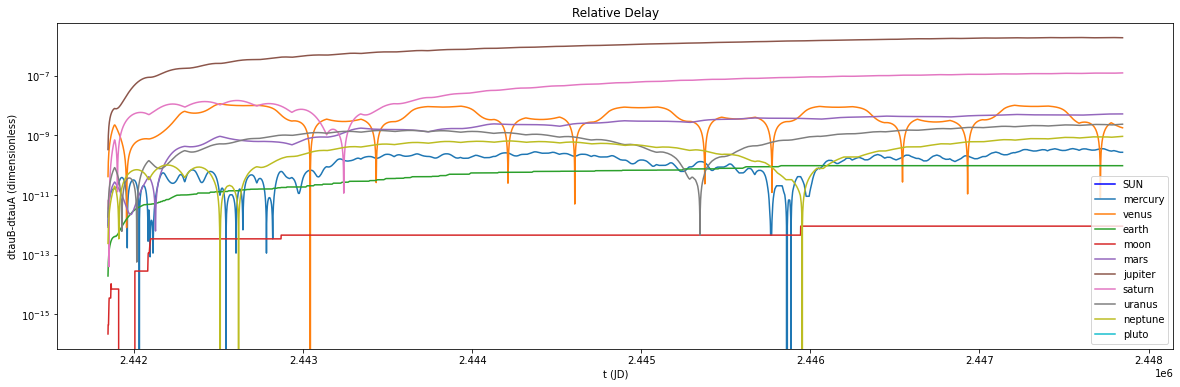

In [39]:
int_delay4 = IntDelta_t(L4_4,L5_4,1,t4,solar_bodies,ss_mass,allpos4)

In [40]:
t_i2 = Time("1966-10-02 11:11")
output5 = Orbits (t_i2, 2, 20000, 20000, solar_bodies,False, False)
allpos5, t5 = output5[0], output5[1]
lp5 = output5[2]

D = 2
end time = 2021-07-05 11:10:28.025
[-4.39764298e-06 -1.36776752e-03  3.22136736e-03] [-1.74279432e-05 -1.04810281e-03  2.44306830e-03]


In [41]:
L1_5 = lp5[0]
L2_5 = lp5[1]
L3_5 = lp5[2]
L4_5 = lp5[3]
L5_5 = lp5[4]

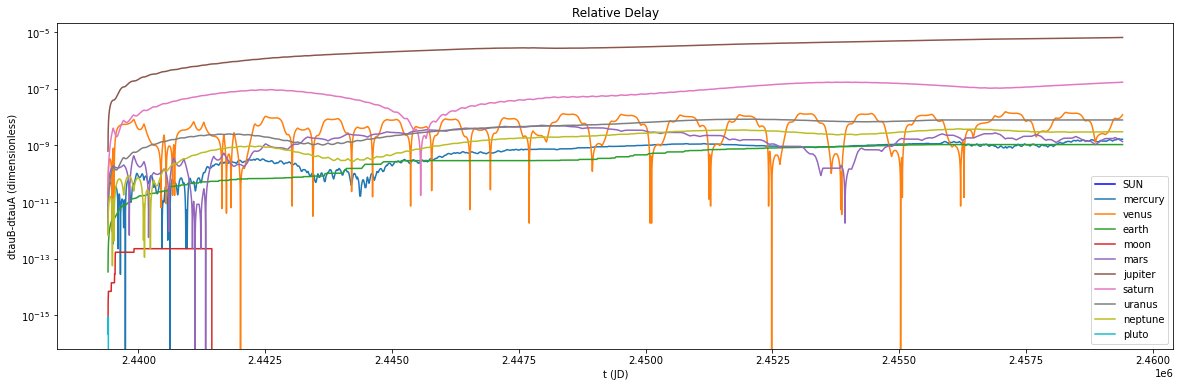

In [42]:
int_delay5 = IntDelta_t(L4_5,L5_5,1,t5,solar_bodies,ss_mass,allpos5)

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


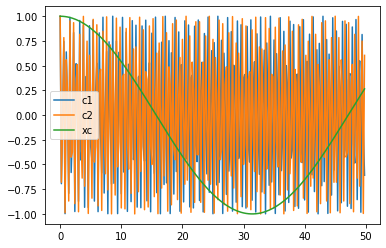

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


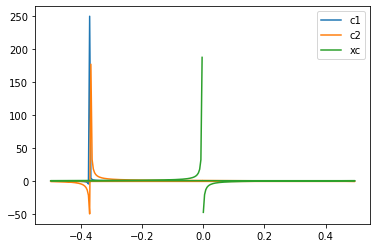

In [43]:
#%%capture 
#CLOCK SIGNALS

def Potential(M,r):
    return -(G*M)/(r*AU*((c)**2)) #nah

def clock(PHI,dt,omega=1e9,phase=0,A=1):
    """
    CLOCK SIGNAL 
    for dimensionless delay PHI (time t, position x)
        coordtime dt - to integrate over (JD)
        fundamental freq omega
        arb. phase
        arb. amp A
    """
    img = (1+PHI)*omega*dt
    expot = complex(phase,img)
    c_signal = A*(np.exp(expot))
    
    return c_signal


def cc(c1,c2):
    """
    cross-correlate c1&c2
    """
    return c1*np.conjugate(c2)

t = np.arange(0,50,0.2)
phi1 = 3e-10
phi2 = 4e-10

c1_sig = np.zeros([len(t)],dtype=complex)
c2_sig = np.zeros([len(t)],dtype=complex)
xc_sig = np.zeros([len(t)],dtype=complex)

for i in range(len(t)):
    c_i_1 = clock(phi1,t[i])
    c1_sig[i]=c_i_1
    
    c_i_2 = clock(phi2,t[i])
    c2_sig[i]=c_i_2
    
    xc_sig[i]=cc(c_i_1,c_i_2)

plt.figure()
plt.plot(t,c1_sig,label='c1')
plt.plot(t,c2_sig,label='c2')
plt.plot(t,xc_sig,label='xc')
plt.legend()
plt.show()

#FT
f = np.fft.fftfreq(t.shape[-1])
spc1 = np.fft.fft(c1_sig)
spc2 = np.fft.fft(c2_sig)
spxc = np.fft.fft(xc_sig)

plt.figure()
plt.plot(f,spc1,label='c1')
plt.plot(f,spc2,label='c2')
plt.plot(f,spxc,label='xc')
plt.legend()
plt.show()

In [44]:
delay1 = int_delay3[0]
delay2 = int_delay3[1]
reldelay = int_delay3[2]

In [45]:
def CC_Clock(R1, R2, dt, t = t3, tauA = delay1, tauB = delay2, rel_tau=reldelay, bodies = solar_bodies, masses=ss_mass, pos = allpos):
    """
    WE DO NOT INTEGRATE FOR NOW
    """
    
    #clock1
    c_sig1 = np.empty([len(bodies),int(len(t)/dt)]) #NB sample size lent/dt must be an int
    
    #clock2
    c_sig2 = np.empty([len(bodies),int(len(t)/dt)])
    
    #cross-correlated signal
    cc_sig = np.empty([len(bodies),int(len(t)/dt)])
    
    #no.days
    N_days = np.arange(len(t))
    days = np.linspace(t.jd[0],t.jd[-1],int(len(t)/dt))
    
    #calculate clock signal at each dt for mass i, distance j
    for i in range(len(c_sig1)):
        for j in range(len(c_sig1[0])):
            c1 = clock(tauA[i][j],dt,1e9)
            c2 = clock(tauB[i][j],dt,1e9)
            xc = clock((rel_tau[i][j]),dt,1e9)
            c_sig1[i][j] = c1
            c_sig2[i][j] = c2
            cc_sig[i][j] = cc(c1,c2)
            cc_sig[i][j] = xc
 

    #PLOT
    plt.figure(figsize=(20,6))
    plt.plot(days,cc_sig[0].real,label="SUN",color='b')
    for i in range(1,len(cc_sig)):
        plt.plot(days, cc_sig[i].real, label=bodies[i])
    plt.xlabel('t (JD)')
    plt.ylabel('cross-correlated clock signal')
    plt.yscale('log')
    plt.legend()
    plt.title('cross-correlated clocks')
    plt.show()
    
    #print(c_sig1[0])
    #print(c_sig2[0])
    #print(cc_sig[0])
    
    #FT time -> freq
    f = np.fft.fftfreq(days.shape[-1])
    plt.figure(figsize=(20,6))
    plt.plot(f,np.fft.fft(cc_sig[0]),label='SUN',color='b')
    for i in range(1,len(cc_sig)):
        plt.plot(f,np.fft.fft(cc_sig[i]),label=bodies[i])
    plt.xlabel('frequency')
    plt.ylabel('FT signal')
    plt.title('x-correlated signals power spectrum')
    plt.legend()
    plt.show()
    
   
    for i in range(len(bodies)):
        plt.figure(figsize=(20,6))
        plt.plot(days, c_sig1[i], label='1')
        plt.plot(days, c_sig2[i], label='2')
        plt.plot(days, cc_sig[i], label='x-correlated')
        plt.title(bodies[i])
        plt.legend()
        plt.yscale('log')
        plt.xlabel('t (JD)')
        plt.ylabel('clock signal')
        plt.show()
    
    #PLOT FT (VENUS)
    
        spc1 = np.fft.fft(c_sig1[i])
        spc2 = np.fft.fft(c_sig2[i])
        spxc = np.fft.fft(cc_sig[i])

        plt.figure(figsize=(20,6))
        plt.plot(f,spc1,label='1')
        plt.plot(f,spc2,label='2')
        plt.plot(f,spxc,label='xc')
        plt.title(bodies[i])
        plt.xlabel('frequency')
        plt.ylabel('FT signal')
        plt.legend()
        plt.show() 
    
    return c_sig1, c_sig2, cc_sig


<ipython-input-45-cd156079a8e3>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  c_sig1[i][j] = c1
<ipython-input-45-cd156079a8e3>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  c_sig2[i][j] = c2
<ipython-input-45-cd156079a8e3>:27: ComplexWarning: Casting complex values to real discards the imaginary part
  cc_sig[i][j] = cc(c1,c2)
<ipython-input-45-cd156079a8e3>:28: ComplexWarning: Casting complex values to real discards the imaginary part
  cc_sig[i][j] = xc


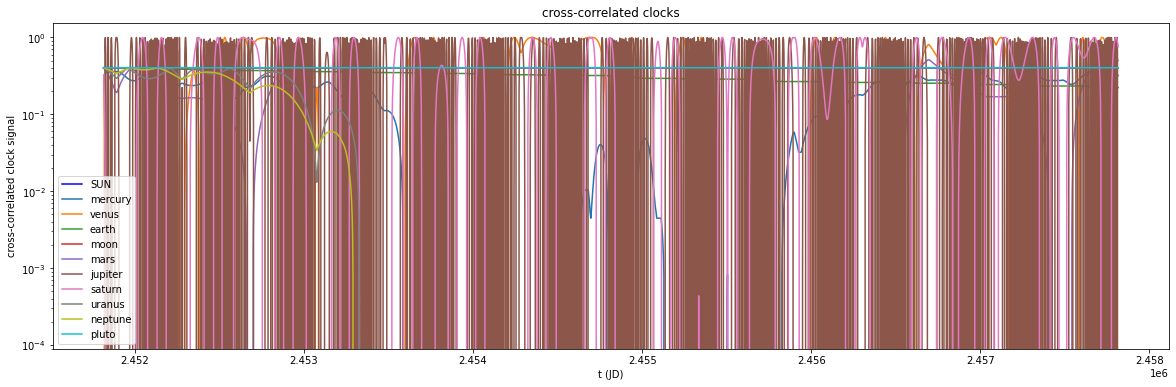

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dt

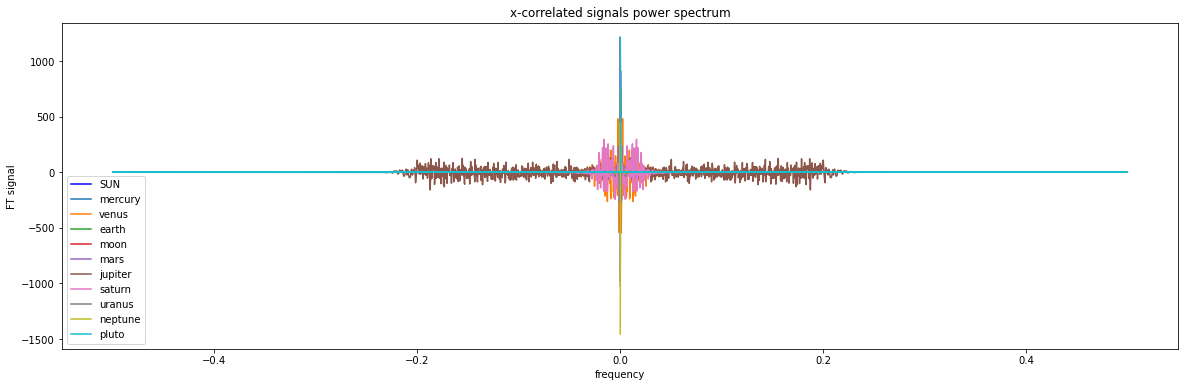

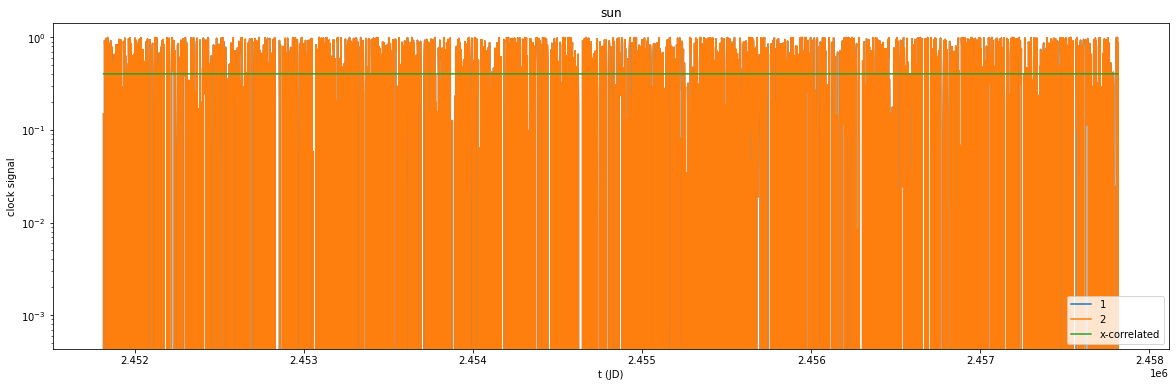

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


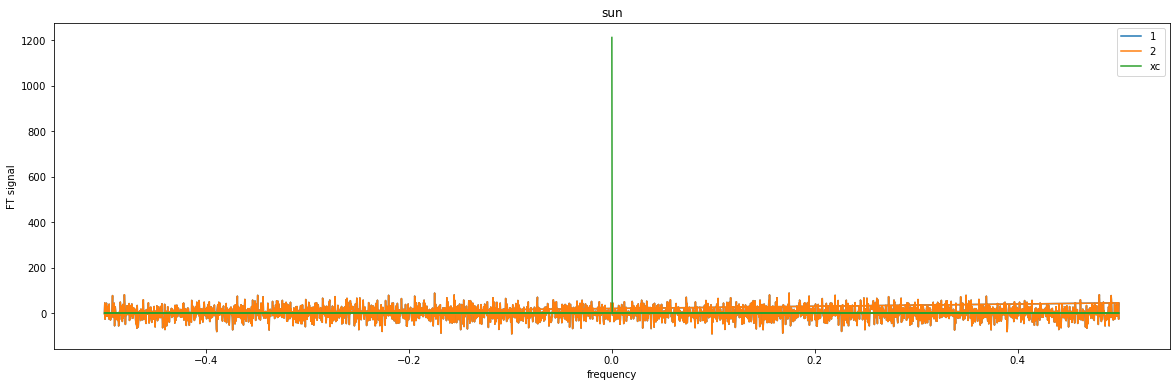

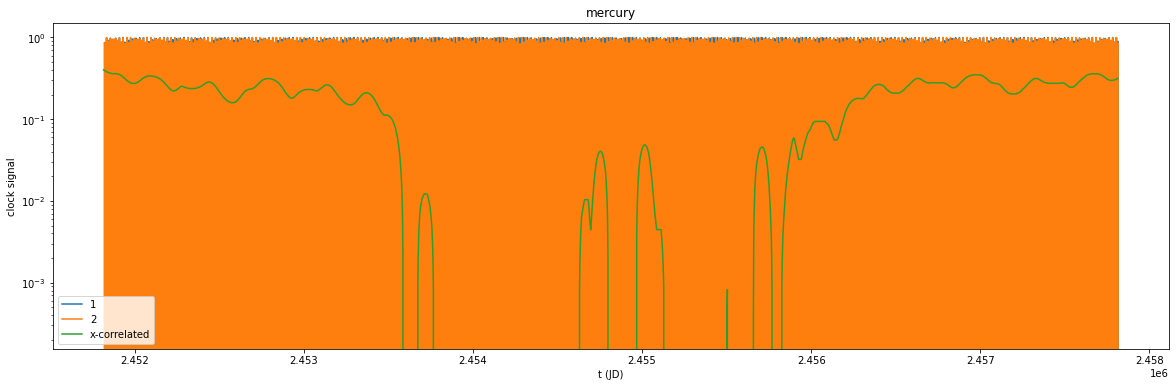

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


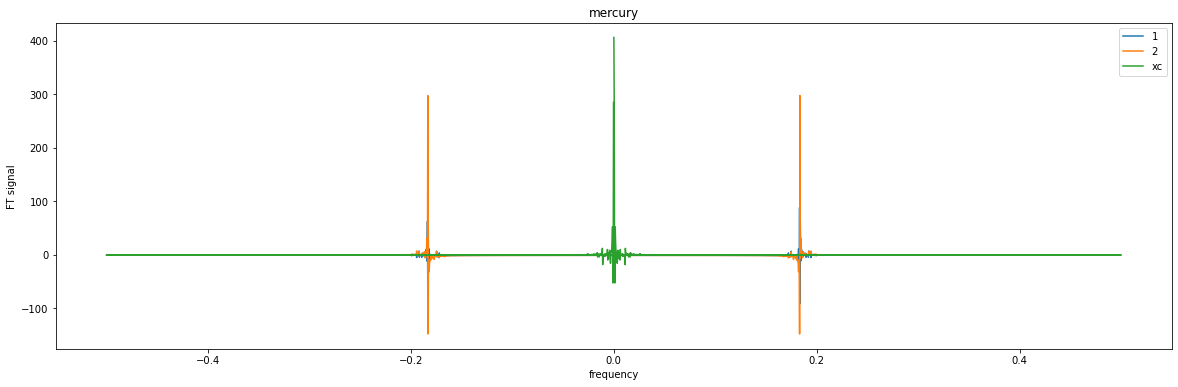

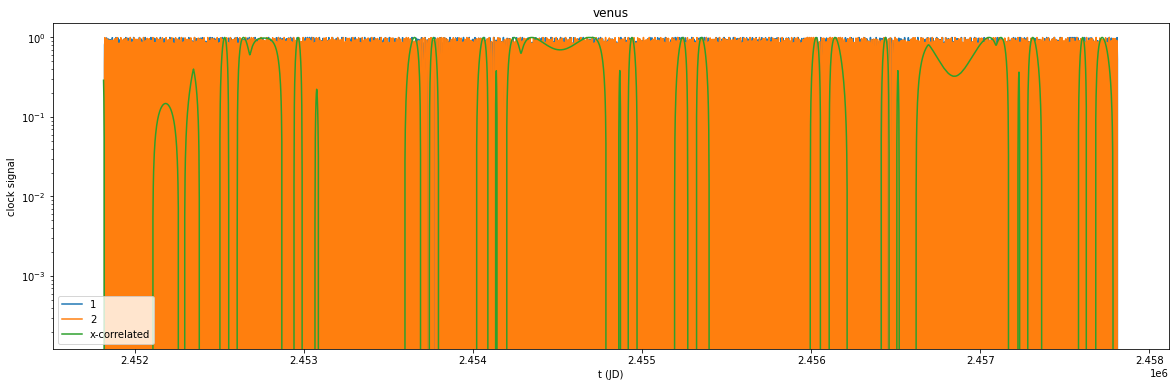

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


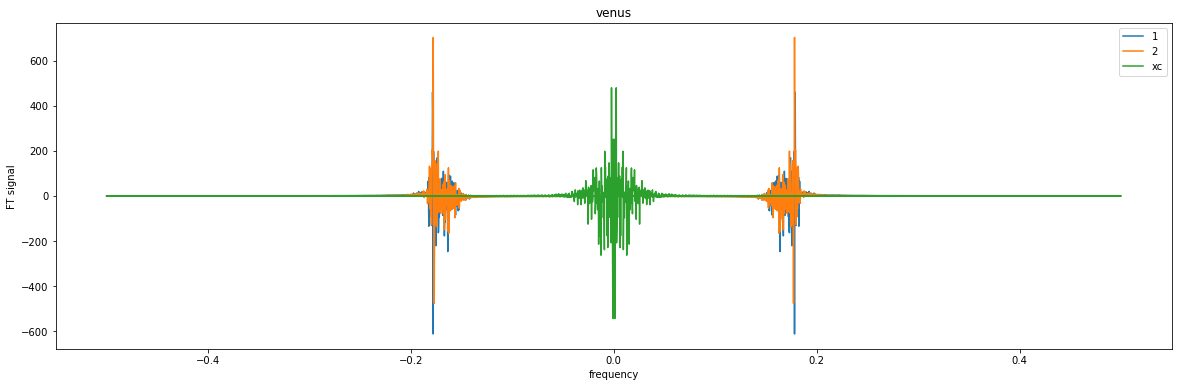

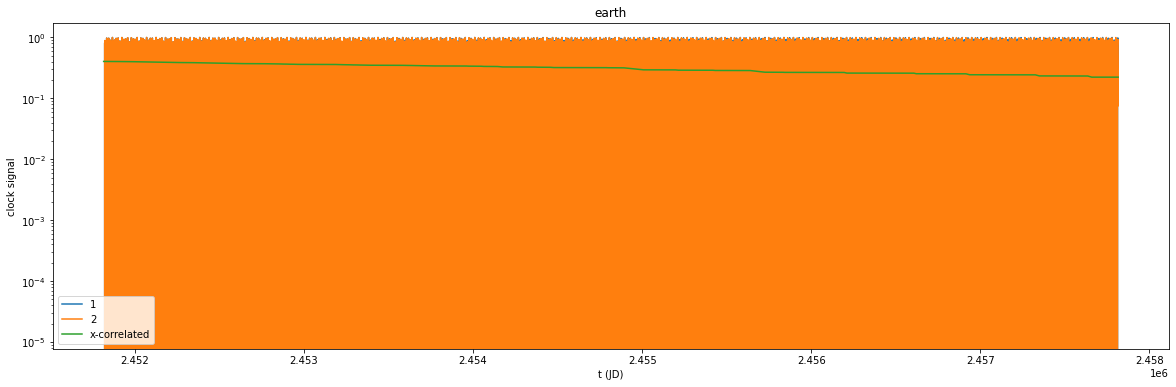

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


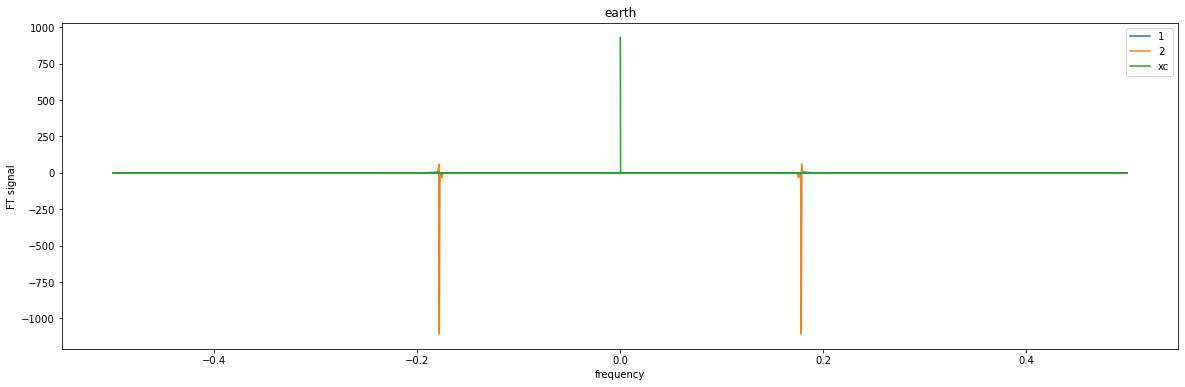

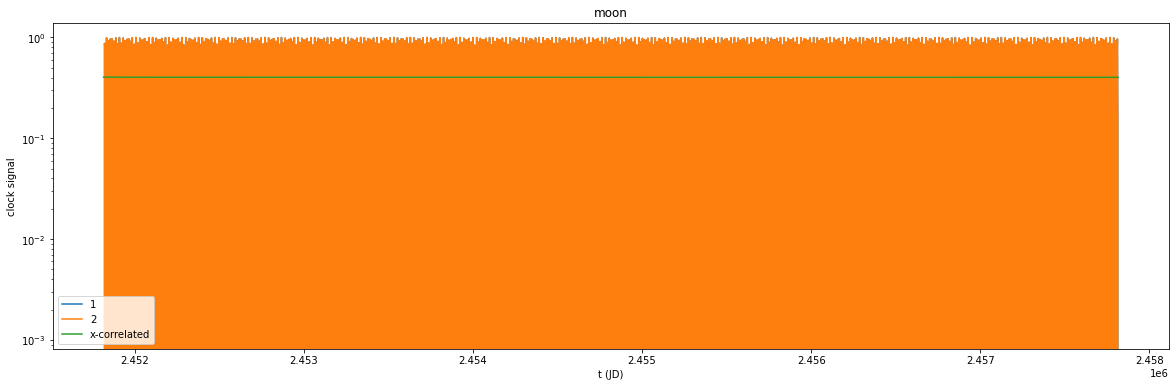

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


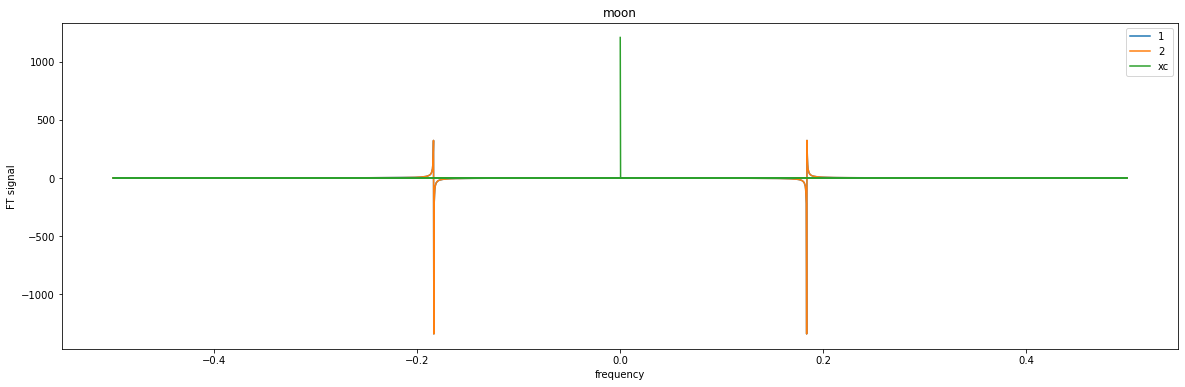

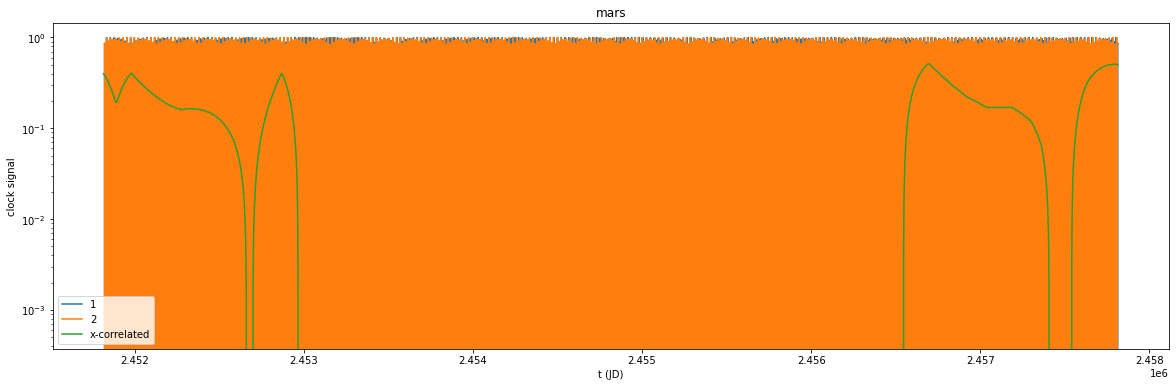

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


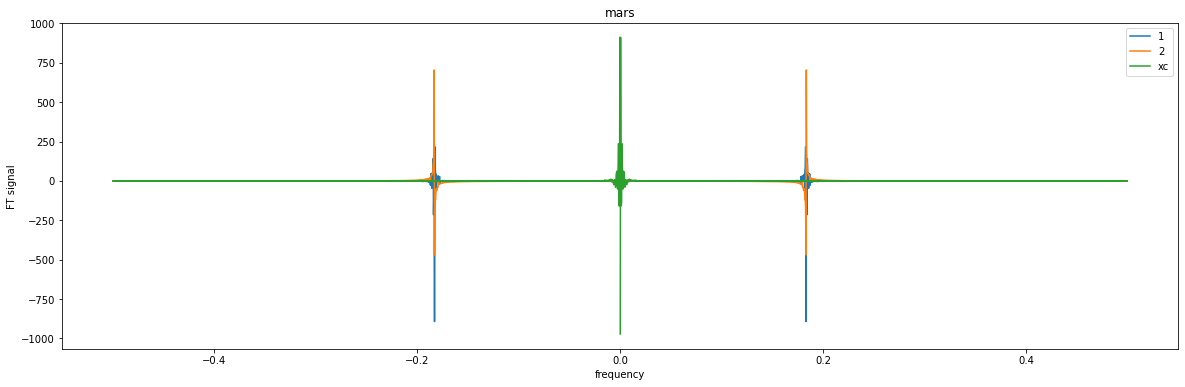

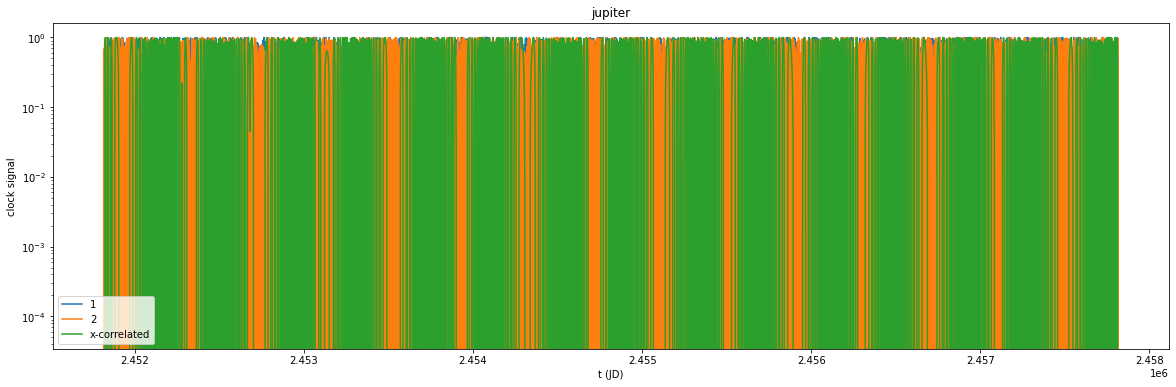

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


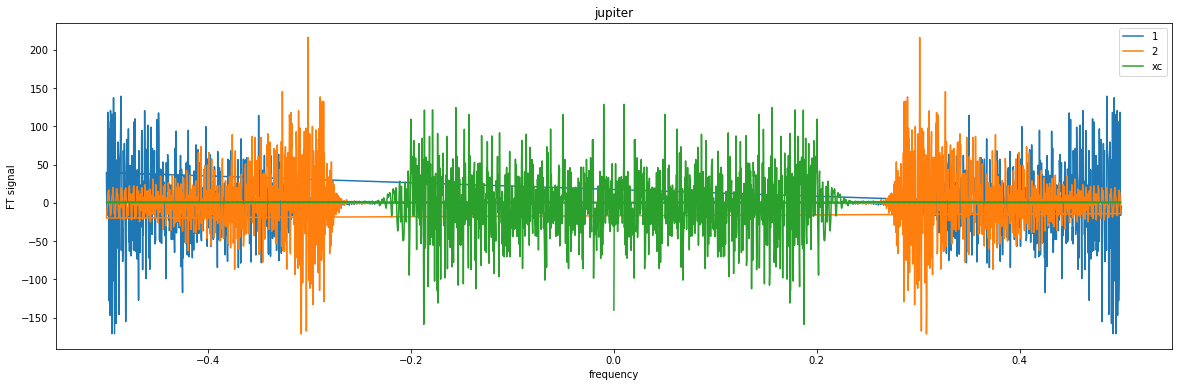

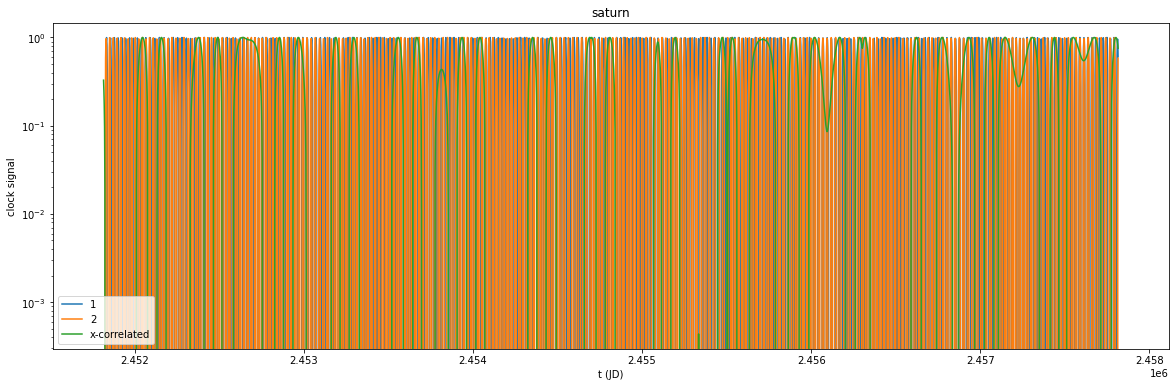

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


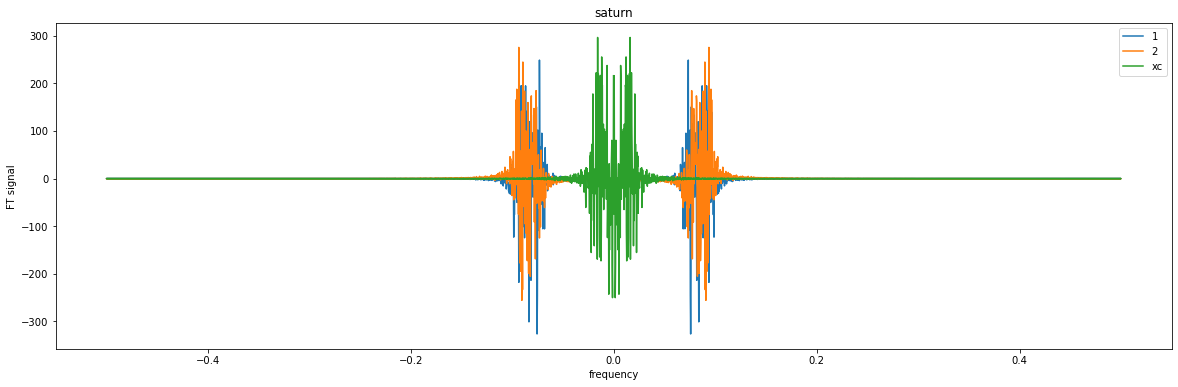

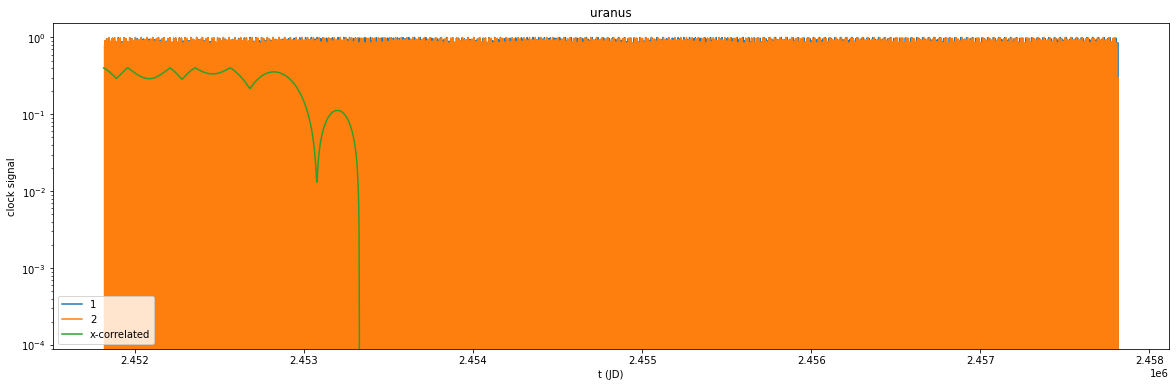

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


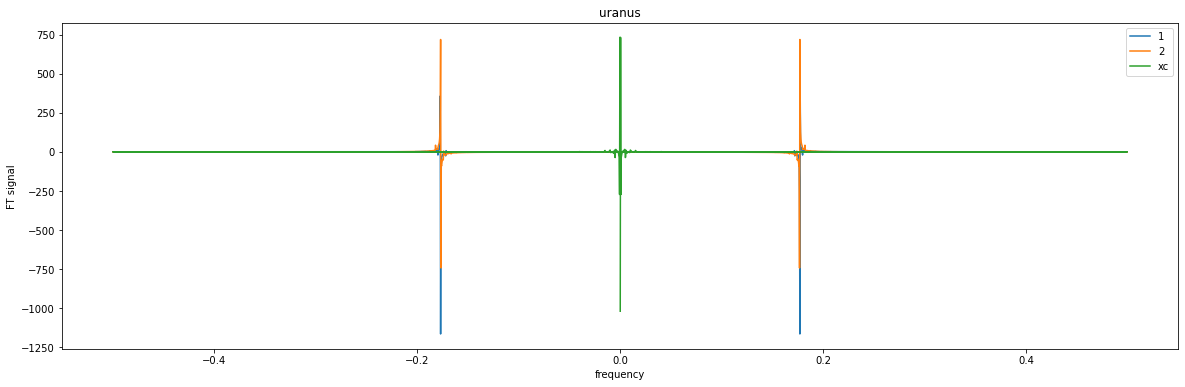

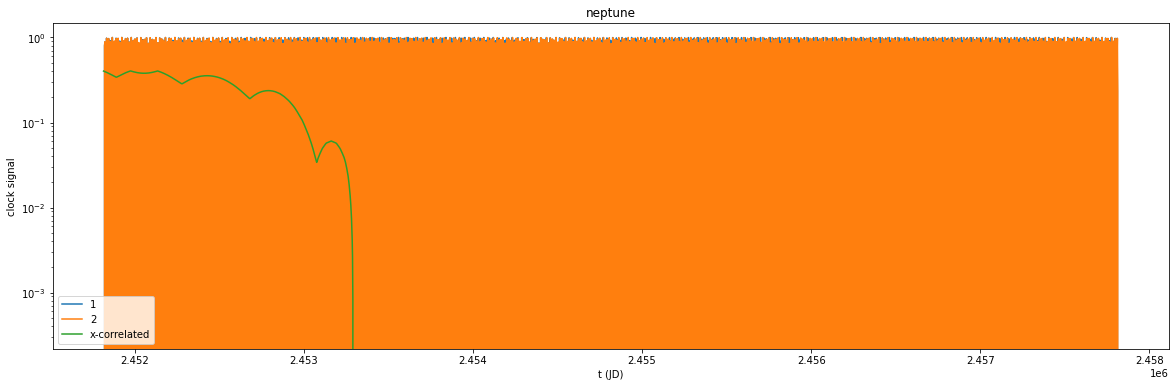

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


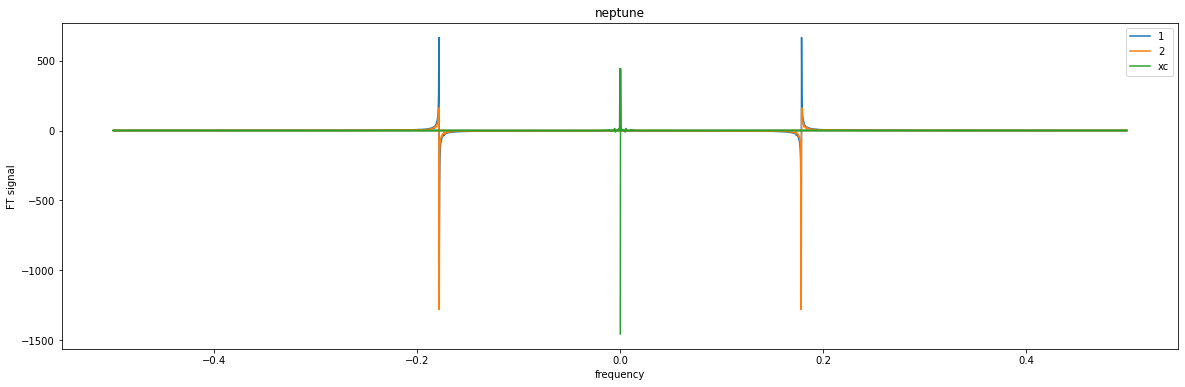

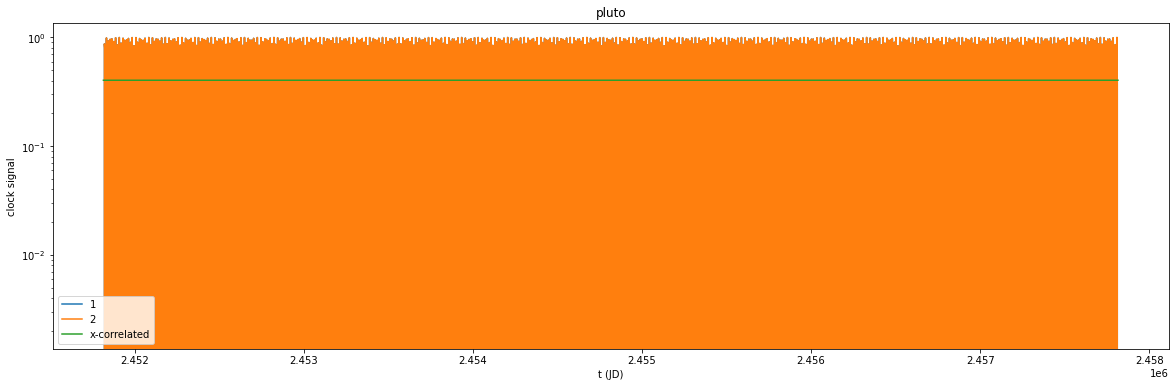

/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/rsxy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


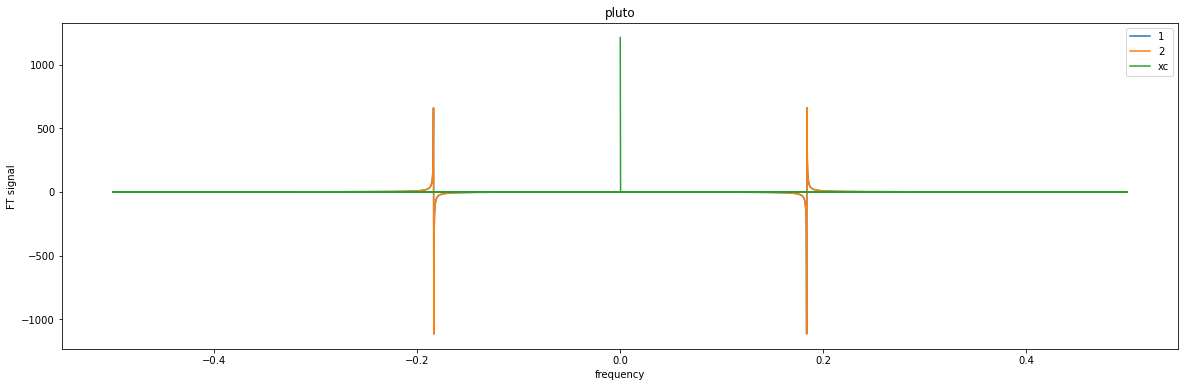

In [46]:
testoutput = CC_Clock(L4_3,L5_3,2)

In [47]:
#NOISE
#for a simple signal
def TESTSIGNAL (x):
    return np.cos(x)

def TESTSIGNAL2 (x):
    return 3*(np.sin(2*x))
    
def NOISE (N,n):
    #Const N, generate n data in total
    sigma = np.sqrt(N/2)
    n_r = np.random.normal(0,sigma,n)
    n_i = np.random.normal(0,sigma,n)
    noise = np.zeros([n],dtype=complex)
    for i in range(n):
        noise[i] = complex(n_r[i],n_i[i])
    return noise

def Range (data):
    return np.max(data) - np.min(data)

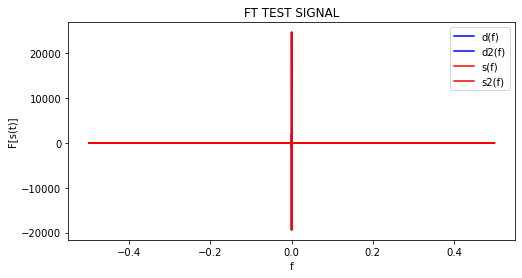

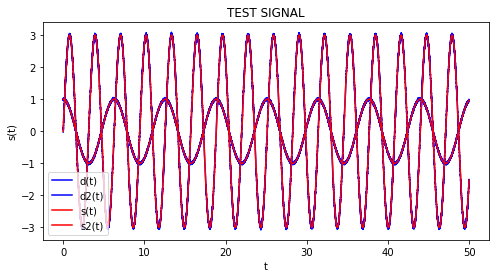

In [52]:
test_t = np.arange(0,50,0.001)
test_sig = []
test_sig2 = []

for i in range (len(test_t)):
    test_sig.append(TESTSIGNAL(test_t[i]))
    test_sig2.append(TESTSIGNAL2(test_t[i]))

#FFT
test_freq = np.fft.fftfreq(test_t.shape[-1])
test_sig_f = np.fft.fft(test_sig)
test_sig_f2 = np.fft.fft(test_sig2)


#GENERATE NOISE IN FOURIER DOMAIN AND ADD TO SIGNAL
n_f = NOISE(0.001*Range(test_sig_f),len(test_t))
n_f2 = NOISE(0.001*Range(test_sig_f2),len(test_t))

d_f = test_sig_f + n_f #data(f) = signal(f) + noise(f)
d_f2 = test_sig_f2 + n_f2
            
plt.figure(figsize = (8,4))
plt.plot(test_freq,d_f,label='d(f)',color='b') #signal + noise
plt.plot(test_freq,d_f2,label='d2(f)',color='b')
plt.plot(test_freq,test_sig_f,label='s(f)',color='red') #signal
plt.plot(test_freq,test_sig_f2,label='s2(f)',color='red')
plt.title('FT TEST SIGNAL')
plt.xlabel('f')
plt.ylabel('F[s(t)]')
plt.legend()
plt.show()
            
#TRANS BACK
plt.figure(figsize=(8,4))
plt.plot(test_t,np.fft.ifft(d_f),label='d(t)',color='b')
plt.plot(test_t,np.fft.ifft(d_f2),label='d2(t)',color='b')
plt.plot(test_t,test_sig,label='s(t)',color='r')
plt.plot(test_t,test_sig2,label='s2(t)',color='r')
plt.title('TEST SIGNAL')
plt.xlabel('t')
plt.ylabel('s(t)')
plt.legend()
plt.show()

test_signals = [test_sig,test_sig2]

def NOISE_SIZE(mag_noise,sig,n):
    """
    mag_noise- magnitude of noise compared w/ ffted signal
    sig- list of multiple signals [[],[]]
    n- length of data
    """
    noise_size = []
    return
    

In [53]:
def CC_Clock_ftdelay(R1, R2, dt, t = t3, bodies = solar_bodies, masses=ss_mass, pos = allpos):
    """
    WE DO NOT INTEGRATE FOR NOW
    """
    delay_data = IntDelta_t(R1,R2,dt,t,bodies,masses,pos)
    #clock1
    c_sig1 = delay_data[0] #NB sample size lent/dt must be an int
    
    #clock2
    c_sig2 = delay_data[1]
    cc_sig = delay_data[2]
    
    #no.days
    #N_days = np.arange(len(t))
    days = np.linspace(t.jd[0],t.jd[-1],int(len(t)/dt))
    
    #FT time -> freq
    f = np.fft.fftfreq(days.shape[-1])
    plt.figure(figsize=(20,6))
    plt.plot(f,np.fft.fft(cc_sig[0]),label='SUN',color='b')
    for i in range(1,len(cc_sig)):
        plt.plot(f,np.fft.fft(cc_sig[i]),label=bodies[i])
    plt.xlabel('frequency')
    plt.ylabel('FT signal')
    plt.title('x-correlated signals power spectrum')
    plt.legend()
    plt.show()
    
    #+NOISE
    s_f = np.empty([len(bodies),int(len(t)/dt)])
    
    for i in range(len(s_f)):
        for j in range(len(s_f[0])):
            s_f[i][j] = np.fft.fft(cc_sig[i])[j] + NOISE(10e-18,len(t))[j]
    
    plt.figure(figsize = (20,6))
    plt.plot(f,s_f[0],label='SUN',color='b')
    for i in range(1, len(bodies)):
        plt.plot(f,s_f[i],label=bodies[i])
    plt.xlabel('f')
    plt.ylabel('d(f)')
    plt.title('signal+noise power spectrum')
    plt.legend()
    plt.show()
    
    #FFT back
    plt.figure(figsize = (20,6))
    plt.plot(days,np.fft.ifft(s_f[0]),label='SUN',color='b')
    for i in range(1,len(bodies)):
        plt.plot(t,np.fft.ifft(s_f[i]),label=bodies[i])
    plt.xlabel('t(JD)')
    plt.ylabel('d(t)')
    plt.title('signal+noise')
    plt.legend()
    plt.show()
            
    return 


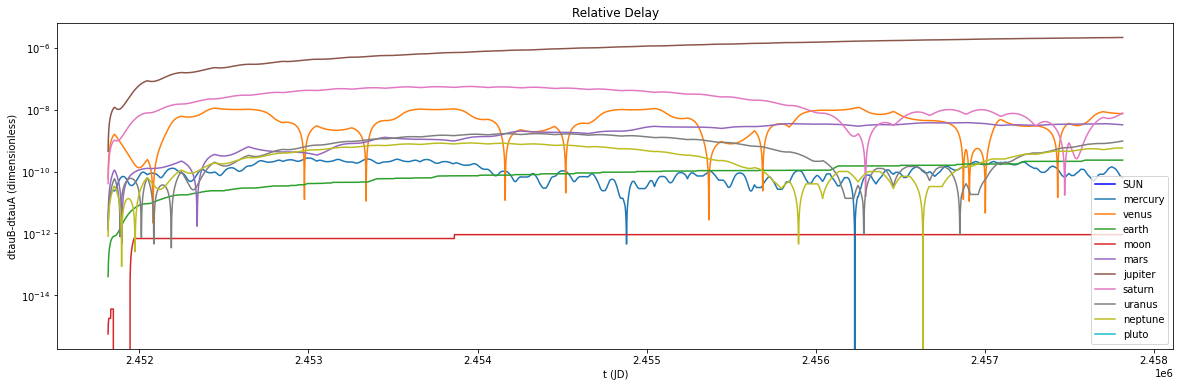

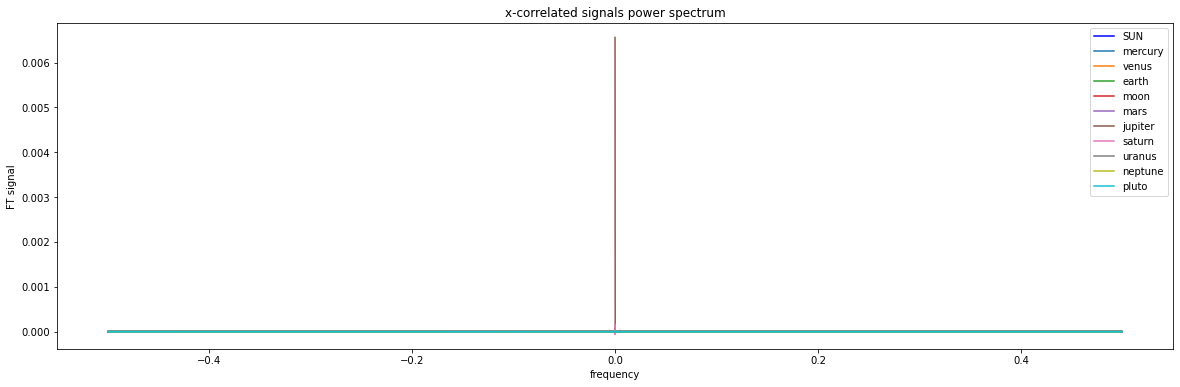

In [ ]:
CC_Clock_ftdelay(L4_3,L5_3,1)